# [BERT] Multiclass text classification 을 활용한 mbti 분류

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 가져오기

In [1]:
import pandas as pd

# 데이터 불러오기
# 16가지의 class labels을 가진 text dataset
df = pd.read_csv('MBTI_min_1000.csv')
# 데이터 그룹화
df = df.groupby(['type'])
# 그룹별 정렬 함수(람다)
func = lambda g: g.sort_values(by = 'type', ascending=False)[:1000]
df = df.apply(func)
df


Unnamed: 0                                              posts  \
type                                                                        
ENFJ 53580       53580  yeah quite like idea actually think could numb...   
     54599       54599  make u look bad comparison hear trouble one ki...   
     54608       54608  get offend annoy question come across selfish ...   
     54607       54607  pretend happen infrequent occasion actually mi...   
     54606       54606  inside feel radiate love feel would try use wo...   
...                ...                                                ...   
ISTP 53157       53157  weird something fond benefit sure put se first...   
     53158       53158  appease curiosity u wot istp friend istps one ...   
     53159       53159  come conclusion simply retard welcome independ...   
     53160       53160  type infj probably see mystic magic stuff thin...   
     53161       53161  task cut friend lowkey feel guiy know example ...   

            type  
type              
ENFJ 53580  ENFJ  
     54599  ENFJ  
     54608  ENFJ  
     54607  ENFJ  
     54606  ENFJ  
...          ...  
ISTP 53157  ISTP  
     53158  ISTP  
     53159  ISTP  
     53160  ISTP  
     53161  ISTP  

[16000 rows x 3 columns]

In [2]:
#pip install transformers

# tokenizer, Embedding

In [11]:
import torch
import numpy as np
from transformers import BertTokenizer

# 토크나이저 설정 : bert-large-uncased 모델
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

labels = {"INFJ" : 0, "INTJ" : 1, "INFP" : 2, "INTP" : 3, "ENFJ" : 4, "ENTJ" : 5,
              "ENFP" : 6, "ENTP" : 7, "ISFJ" : 8, "ISTJ" : 9, "ISFP" : 10, "ISTP" : 11,
                "ESFJ" : 12, "ESTJ" : 13, "ESFP" : 14, "ESTP" : 15}


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # label 리스트 생성
        self.labels = [labels[label] for label in df['type']]
        # df[posts]의 value를 순차적으로 가져와서 토큰화, padding = 512 설정
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['posts']]
    def classes(self):
        # 레이블 리스트 반환
        return self.labels

    def __len__(self):
        # 레이블 리스트 길이 반환
        return len(self.labels)

    def get_batch_labels(self, idx):
        # idx에 해당하는 배치 레이블을 numpy 배열로 변환
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # idx에 해당하는 토큰화된 텍스트 배치를 반환
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [34]:
# 훈련, 검증, 테스트 데이터 분할
df_train, df_val, df_test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])
print(len(df_train),len(df_val), len(df_test))

12800 1600 1600


In [33]:
temp = Dataset(df_test)
print('class 값 : ', temp.labels[0])
print(temp.texts[0])

class 값 :  13
{'input_ids': tensor([[  101, 15775, 22272,  2015,  2330,  2755,  2292,  2518,  2175,  3280,
          1054,  4759,  4215,  7903,  2063,  9765,  3501,  9958, 21541,  4523,
          2467,  3565, 17824,  1038,  7438,  7603, 11581,  2135,  2659,  9991,
          2514,  7570, 28397,  2166,  1039, 19554,  7367,  2812,  2763,  2066,
          2175,  4658,  6172,  3492,  4658,  2801,  2298,  2204,  3661,  2063,
         11808,  7938,  2112,  4728,  6300,  2050,  2215,  4604,  4735,  2067,
          2272,  2404,  3097,  4681,  4681,  2111,  2406,  2612,  5138,  2116,
         13141, 17012,  7382,  7382,  7382,  9765,  3501,  1042,  3102,  4654,
         25856,  1060,  2078,  2546,  3501, 21541,  3501,  9686,  2546,  3501,
          9748, 21541,  2361,  9765,  3501, 20014,  3501,  1042, 11814, 22540,
          2003,  2546,  3501,  4372, 22540,  5914, 11814, 25856,  3398,  2469,
          2092,  5333, 10882,  3928,  2486,  2204,  2619,  6293,  4054,  2750,
          2591,  3778,  

# BERT Fine tuning
### with bert-large-uncased

In [6]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        # 층 생성
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1024, 16)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        
        # 층 적용
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# Train

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)
    
   # 주어진 데이터셋을 배치 단위로 분할,셔플
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    # cpu 사용
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # 손실함수 및 최적화 설정
    # 소프트 맥스 내부적 수행 -> 모델 출력을 확률값으로 변환 -> 손실 계산 -> 역전파 알고리즘을 통해 모델 가중치 업데이트
    criterion = nn.CrossEntropyLoss()
    # 경사 하강법
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
            # GPU 사용하여 모델 연산 가속화
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0 # 총 정확도
            total_loss_train = 0 # 손실

            # train_input == batch_text
            # train_label == batch_y
            for train_input, train_label in tqdm(train_dataloader):

                # label을 gpu로 이동
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                #차원 크기가 1인 차원을 제거하여, input_ids 텐서의 크기를 [batch_size(2),sequence_length(512)]로 조정
                #bert 사용을 위해 차원의 크기가 1인걸 제거해야함
                input_id = train_input['input_ids'].squeeze(1).to(device)


                output = model(input_id, mask) # fit

                # 출력과 정답 레이블 사이의 손실을 계산
                batch_loss = criterion(output, train_label.long())
                # 현재 배치의 손실을 전체 학습 손실에 누적
                total_loss_train += batch_loss.item()
                # 예측 결과와 정답 레이블을 비교하여 정확도를 계산
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                # 모델의 기울기를 0으로 초기화합니다.
                model.zero_grad()
                #
                batch_loss.backward()
                #
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            # 검증 작업
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

EPOCHS = 10
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

# Accuracy and Predict

In [37]:
from tqdm import tqdm

def predict(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    predicted_labels = []  # List to store predicted class values

    with torch.no_grad(), tqdm(total=len(test_data), desc="Evaluation") as pbar:
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            predicted_labels.extend(output.argmax(dim=1).tolist())  # Append predicted class values to the list
            pbar.update(len(test_input))

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    return predicted_labels


# Torch model save

In [ ]:
torch.save(model, f'./large_sample1000_epoch12.pt')

# Torch model Load

In [38]:
model = torch.load('/Users/seongcheollee/Downloads/large_sample1000_epoch12/largemodel_sample1000_epoch12.pt', map_location=torch.device('cpu'))
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, e

# 예측 및 테스트

In [ ]:
df['label'] = [labels[label] for label in df['type']]
# 결과 레이블 컬럼 생성
df['predic_label'] = predict_res
df

posts  type  label  \
type                                                                         
ENFJ 53658  reality objective reality first place time act...  ENFJ      4   
     53657  legitimately worry however obama really fix an...  ENFJ      4   
     53656  thank really hard find decent info sure know f...  ENFJ      4   
     53655  think answer forget sudoku despite complaint l...  ENFJ      4   
     53654  know one type know fell elitist thing first he...  ENFJ      4   
...                                                       ...   ...    ...   
ISTP 50999  pick daisy like kid baseball team want base st...  ISTP     11   
     51000  ft shit would get serious real quick yea istp ...  ISTP     11   
     51001  selflessness help others love care etc downsid...  ISTP     11   
     51002  english music study religion math b well least...  ISTP     11   
     51003  europe launch icbm u surround missile defense ...  ISTP     11   

            predic_label  
type                      
ENFJ 53658             4  
     53657            13  
     53656             4  
     53655             4  
     53654             4  
...                  ...  
ISTP 50999            11  
     51000            11  
     51001            11  
     51002             3  
     51003            11  

[9752 rows x 4 columns]

In [ ]:
df_reset_index = df.reset_index(drop=True)  # 인덱스 재설정

count = df_reset_index[df_reset_index['label'] == df_reset_index['predic_label']].groupby('type').size()
# 예측 성공한 것
print(count)

type
ENFJ    379
ENFP    710
ENTJ    783
ENTP    519
ESTP    912
INFJ    788
INFP    707
INTJ    753
INTP    738
ISTJ    188
ISTP    775
dtype: int64


In [ ]:
all = df_reset_index.groupby('type').size()

print(all)


type
ENFJ    533
ENFP    999
ENTJ    999
ENTP    999
ESTP    985
INFJ    999
INFP    999
INTJ    999
INTP    999
ISTJ    242
ISTP    999
dtype: int64


In [ ]:
count = df_reset_index[df_reset_index['label'] == df_reset_index['predic_label']].groupby('type').size()
all_count = df_reset_index.groupby('type').size()

probability = count / all_count * 100

print(probability)


type
ENFJ    71.106942
ENFP    71.071071
ENTJ    78.378378
ENTP    51.951952
ESTP    92.588832
INFJ    78.878879
INFP    70.770771
INTJ    75.375375
INTP    73.873874
ISTJ    77.685950
ISTP    77.577578
dtype: float64


In [ ]:
result_df = pd.DataFrame({'predict_count': count, 'All_count' : all ,'Percentage': probability})
print(result_df)

      predict_count  All_count  Percentage
type                                      
ENFJ            379        533   71.106942
ENFP            710        999   71.071071
ENTJ            783        999   78.378378
ENTP            519        999   51.951952
ESTP            912        985   92.588832
INFJ            788        999   78.878879
INFP            707        999   70.770771
INTJ            753        999   75.375375
INTP            738        999   73.873874
ISTJ            188        242   77.685950
ISTP            775        999   77.577578


# 결과 DataFrame 반환 함수

In [42]:
def calculate_prediction_stats(df, predict):

    labels = {"INFJ": 0, "INTJ": 1, "INFP": 2, "INTP": 3, "ENFJ": 4, "ENTJ": 5,
              "ENFP": 6, "ENTP": 7, "ISFJ": 8, "ISTJ": 9, "ISFP": 10, "ISTP": 11,
              "ESFJ": 12, "ESTJ": 13, "ESFP": 14, "ESTP": 15}

    # label, predic_label 값 입력
    df['label'] = [labels[label] for label in df['type']]
    df['predic_label'] = predict
    # groupby 를 위한 인덱스 재설정
    df_reset_index = df.reset_index(drop=True)
    # 예측 성공 column
    count = df_reset_index[df_reset_index['label'] == df_reset_index['predic_label']].groupby('type').size()
    # 전체 수 column
    all_count = df_reset_index.groupby('type').size()
    # 확률 column
    probability = count / all_count * 100

    # dataFrame 생성
    result_df = pd.DataFrame({'predict_count': count, 'All_count': all_count, 'Percentage': probability})
    result_df.fillna(0, inplace=True)

    return result_df

#result_df = calculate_prediction_stats(df,predict_res)
#print(result_df)


# 분류 실패 mbti 유형 시각화

In [56]:
df = pd.read_csv('grouped_diff.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,label,predic_label,count
0,0,1,26
1,0,2,37
2,0,3,15
3,0,4,25
4,0,5,5
...,...,...,...
153,15,9,5
154,15,10,2
155,15,11,29
156,15,13,4


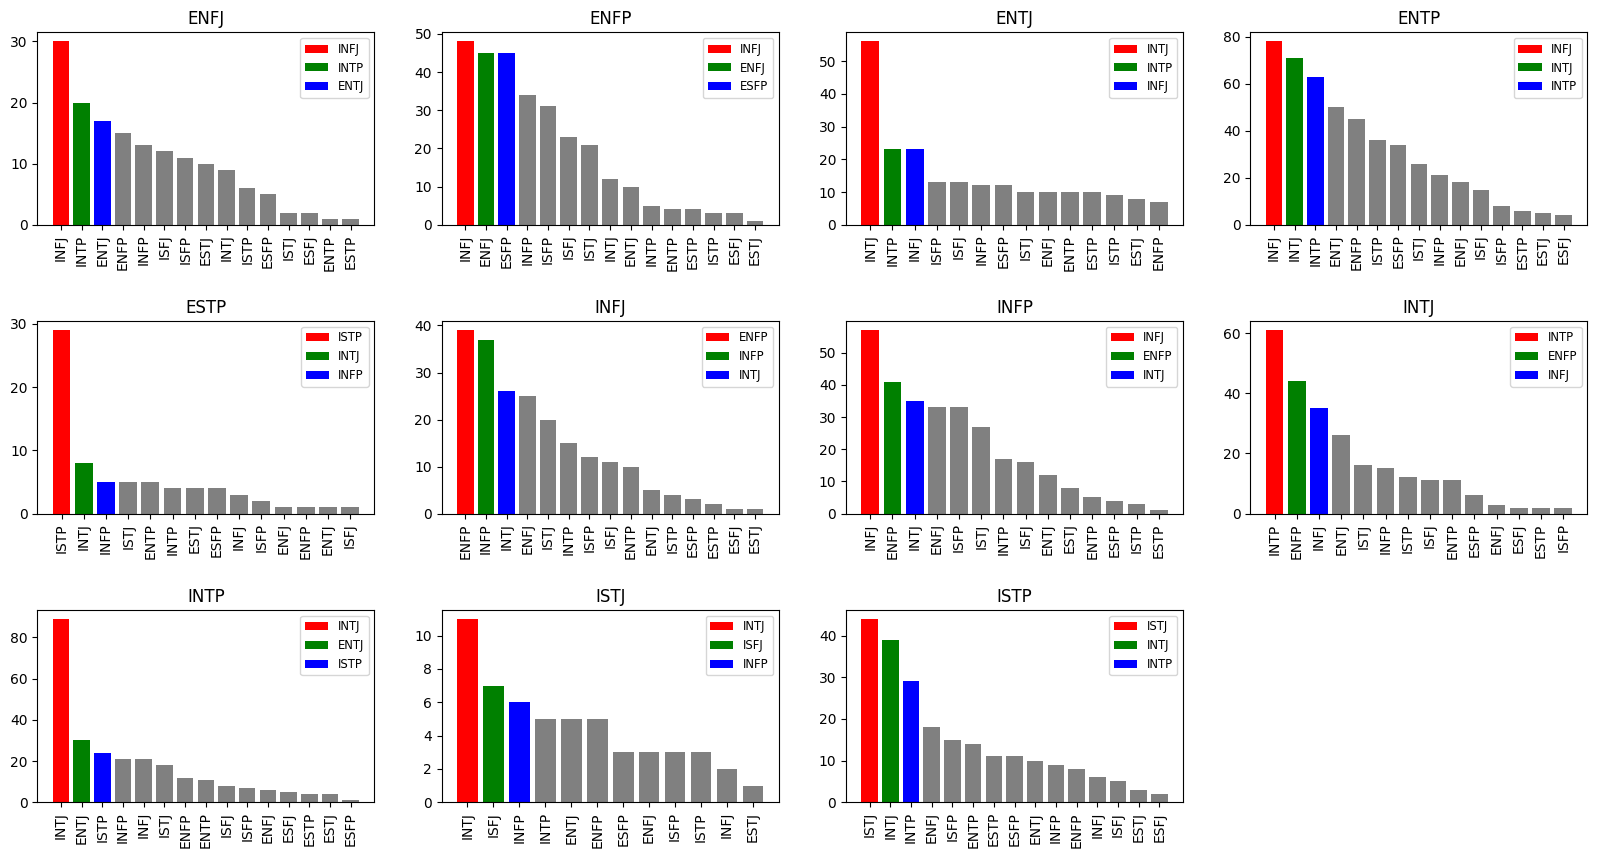

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

labels = {0: "INFJ", 1: "INTJ", 2: "INFP", 3: "INTP", 4: "ENFJ", 5: "ENTJ",
          6: "ENFP", 7: "ENTP", 8: "ISFJ", 9: "ISTJ", 10: "ISFP", 11: "ISTP",
          12: "ESFJ", 13: "ESTJ", 14: "ESFP", 15: "ESTP"}

df['label'] = df['label'].map(labels)
df['predic_label'] = df['predic_label'].map(labels)

import pandas as pd
import matplotlib.pyplot as plt

# 레이블 별 예측 레이블의 카운트 계산 및 count 값으로 정렬
label_counts = df.groupby(['label', 'predic_label']).sum().reset_index()
label_counts = label_counts.sort_values('count', ascending=False)

# 색상 리스트 생성
colors = ['r', 'g', 'b']

# 카운트 서브그래프 생성
fig, axs = plt.subplots(3, 4, figsize=(20, 10))  # nrows를 3, ncols를 4로 설정
fig.subplots_adjust(hspace=0.5)
labels = sorted(label_counts['label'].unique())

for i, label in enumerate(labels):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    counts = label_counts[label_counts['label'] == label]
    
    # 상위 3개 레이블 추출
    top_labels = counts.nlargest(3, 'count')['predic_label']
    legend_labels = [str(lbl) for lbl in top_labels]
    
    # 막대 색상 지정 및 그리기
    for j, lbl in enumerate(top_labels):
        color = colors[j % len(colors)]  # 순환적으로 색상 선택
        ax.bar(lbl, counts[counts['predic_label'] == lbl]['count'], color=color)
    
    # 나머지 막대 회색으로 그리기
    non_top_labels = counts[~counts['predic_label'].isin(top_labels)]['predic_label']
    ax.bar(non_top_labels, counts[counts['predic_label'].isin(non_top_labels)]['count'], color='gray')
    
    # 예측 레이블 이름 추가 및 세로 표시
    ax.set_xticks(counts['predic_label'])
    ax.set_xticklabels(counts['predic_label'], rotation='vertical')
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('{}'.format(label))
    
    # 범례를 서브그래프 내부에 추가
    ax.legend(legend_labels, loc='upper right', fontsize='small')

# 서브그래프 레이아웃 조정
if len(labels) < 12:  # 총 3줄이므로 12개보다 적은 경우에만 조정
    for i in range(len(labels), 12):
        row = i // 4
        col = i % 4
        fig.delaxes(axs[row, col])

plt.show()

